In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t, shapiro, kstest, anderson, mstats, pearsonr, probplot, kruskal
from scipy.stats import ttest_1samp, f_oneway, spearmanr, kendalltau, chisquare, ttest_rel, ttest_ind
from mlxtend.evaluate import permutation_test
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as ss

def ECDF(x):
    n = len(x)
    x = np.sort(x)
    y = np.arange(1,n+1)/n
    return x,y

def ECDF_plot(x, title, xlabel):
    plt.figure(figsize=(10,8))
    plt.plot(ECDF(x)[0], ECDF(x)[1], marker='.', linestyle='none', c='#000000')
    plt.title(title, fontsize=20, color='blue')
    plt.xlabel('scores', fontsize=10)
    plt.ylabel('Density', fontsize=10, rotation=0)
    plt.show()
    


best random mean: 7.5025
best random std: 1.5015094904794977
best random iteration: 5792


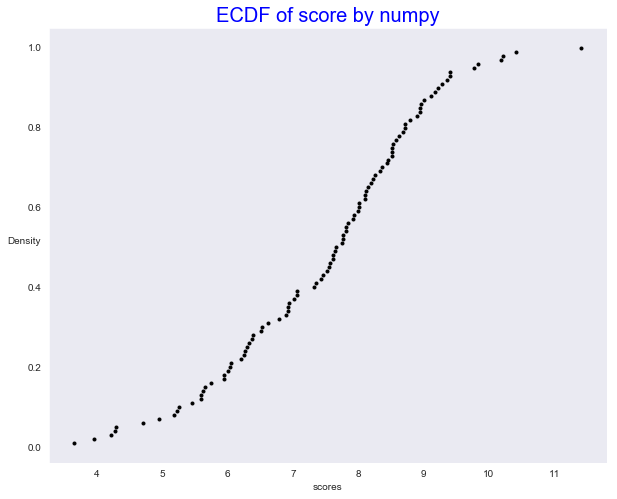

In [202]:
#Ex1
mean = 7.5
std = 1.5

def square(best_mean, best_std, iteration):
    best_square = 100
    bestMean = best_mean
    bestStd = best_std
    for i in range(1, iteration + 1):
        np.random.seed(i)
        score = np.random.normal(best_mean, best_std, 100).round(2)
        mean2 = np.mean(score)
        std2 = np.std(score)
        square_error = np.sqrt((mean2 - best_mean)**2 + (std2 - best_std)**2)
        if square_error < best_square:
            best_iteration = i
            best_square = square_error
            bestMean = mean2
            bestStd = std2
            
    print('best random mean:', bestMean)
    print('best random std:', bestStd)
    print('best random iteration:', best_iteration)
    return score

score = square(mean, std, 10000)

ECDF_plot(score, 'ECDF of score by numpy', 'score')

py_scores = pd.DataFrame()
py_scores['Score'] = score
py_scores.to_csv('./bt/py_stores.csv', index=False)

In [89]:
#Ex2
df = pd.read_csv('./bt/py_stores.csv')

# H0: Average score is not higher than 6.8
# H1: Average score is higher than 6.8

t_test = ttest_1samp(df['Score'], 6.8)


def hypothesis(anpha, p):
    if p/2 > anpha:
        print("Can't reject H0")
    else:
        print('reject H0')
    return  p

t_test = hypothesis(0.05, t_test[1])
print('t test: %f'% (t_test))

# t>0 and p/2<0.05 then reject H0

Ttest_1sampResult(statistic=4.284653344183164, pvalue=4.247639466859359e-05)
reject H0
t test: 0.000042


reject H0


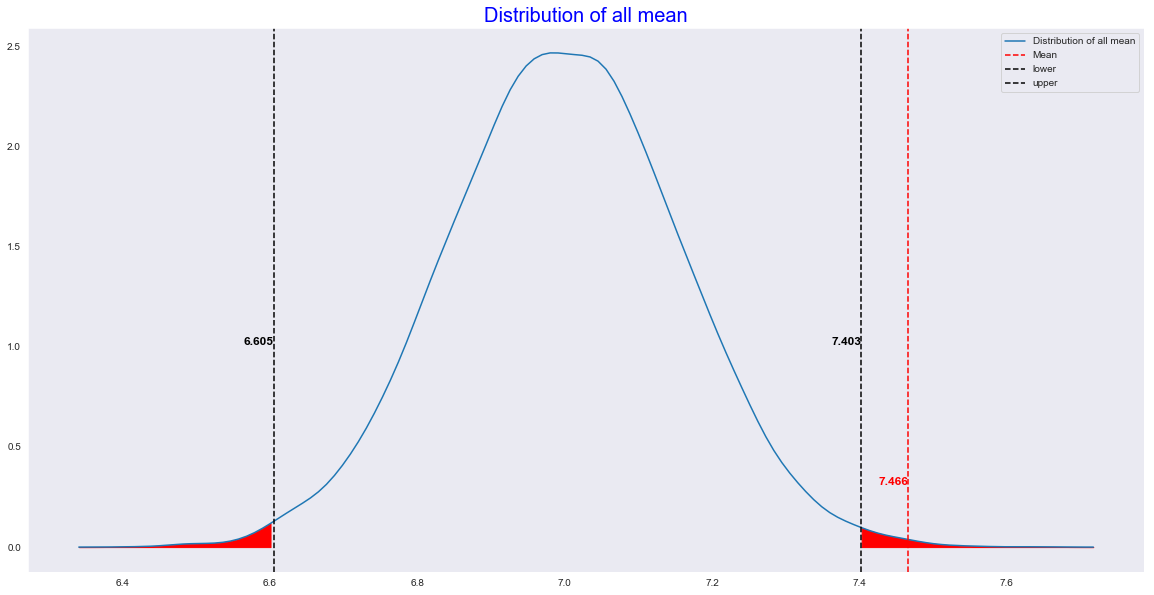

0.0013

In [204]:
#Ex3
df = pd.read_csv('./bt/py_stores.csv')

# H0: Average score is equal 7.0
# H1: Average score is higher than 7.0


def bootstrap(data, number_in_choice, anpha, value, size, ss):
    
    list_mean = np.zeros(size)
    
    for i in range(size):
        np.random.seed(i)
        data_shuffle = data - np.mean(data) + value
        sample = np.random.choice(data_shuffle, number_in_choice)
        list_mean[i] = np.mean(sample)
        
    if ss == 1:
        p = np.sum(list_mean>=np.mean(data))/size
    else:
        p = np.sum(list_mean<=np.mean(data))/size
    
    if p > anpha:
        print("Can't reject H0")
    else:
        print('reject H0')
    
    lower, upper = np.percentile(list_mean, [100*anpha/2,100*(1-anpha/2)])
    
    plt.figure(figsize=(20,10))
    ax = sns.distplot(list_mean, hist=False, label='Distribution of all mean')
        
    
    plt.axvline(np.mean(data), ls='--', label='Mean', color='r')
    plt.text(np.mean(data), 0.3, "{:.3f}".format(np.mean(data)), horizontalalignment='right', verticalalignment='bottom', fontweight='bold', fontsize=12, color='r')
    
    plt.axvline(lower, ls='--', color='k', label='lower')
    plt.text(lower, 1, "{:.3f}".format(lower), horizontalalignment='right', verticalalignment='bottom', fontweight='bold', fontsize=12, color='k')
    
    plt.axvline(upper, ls='--', color='k', label='upper')
    plt.text(upper, 1, "{:.3f}".format(upper), horizontalalignment='right', verticalalignment='bottom', fontweight='bold', fontsize=12, color='k')

    line = ax.get_lines()[0]
    x, y = line.get_data()
    
    x0 = x<lower
    x0_ = x>upper
    x1, y1 = x[x0], y[x0]
    x2, y2 = x[x0_], y[x0_]
    plt.fill_between(x1, y1, color='r')
    plt.fill_between(x2, y2, color='r')

    plt.title('Distribution of all mean', fontsize=20, color='blue')
    plt.legend(loc='upper right')
    plt.show()
    
    return p
    

data = df['Score']
number_in_choice = len(df['Score'])
anpha = 0.01
value = 7.0



size = 10000

bootstrap(data, number_in_choice, anpha, value, size, 1)

# p/2 < 0.01 then reject H0 with CI = 99%

reject H0


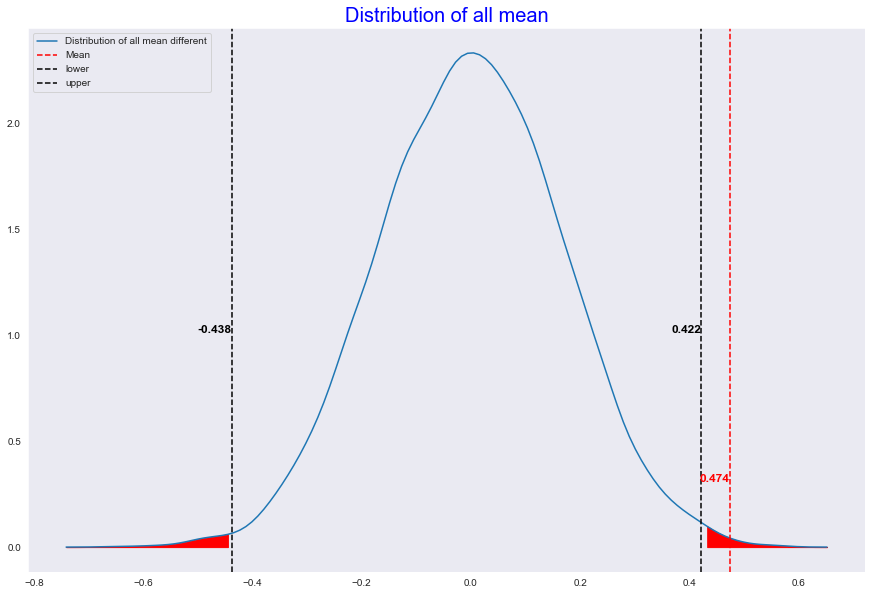

0.0016

In [90]:
#Ex4
score = pd.read_csv('./bt/py_stores.csv')
sql = df = pd.read_csv('./Assignment 8 Data Files/sql_scores.csv', header=None, names=['Sql'])

#muy0 = muy(score)
#muy1 = muy(sql)
#delta_muy = muy1 - muy0

#H0: delta_muy =0
#H1: delta_muy > 0

def permutationTest(sample1, sample0, size, anpha):
    mean_diff = np.mean(sample1) - np.mean(sample0)
    compiled = np.concatenate((sample1, sample0), axis=0)
    matrix_mean = np.zeros((size, 2))
    for i in range(size):
        np.random.seed(i)
        suffle = np.random.permutation(compiled)
        sample_permutation1 = suffle[:len(sample1)]
        sample_permutation0 = suffle[len(sample1)+1:]
        matrix_mean[i,0] = np.mean(sample_permutation1)
        matrix_mean[i,1] = np.mean(sample_permutation0)
    
    result_mean = matrix_mean[:,0] - matrix_mean[:,1]
    
    
    p = (np.sum(result_mean>=mean_diff)/size).round(10)
    
    if p > anpha:
        print("Can't reject H0")
    else:
        print('reject H0')
        
    lower, upper = np.percentile(result_mean, [100*anpha/2,100*(1-anpha/2)])
    
    plt.figure(figsize=(15,10))
    ax = sns.distplot(result_mean, hist=False, label='Distribution of all mean different')
        
    
    plt.axvline(mean_diff, ls='--', label='Mean', color='r')
    plt.text(mean_diff, 0.3, "{:.3f}".format(mean_diff), horizontalalignment='right', verticalalignment='bottom', fontweight='bold', fontsize=12, color='r')
    
    plt.axvline(lower, ls='--', color='k', label='lower')
    plt.text(lower, 1, "{:.3f}".format(lower), horizontalalignment='right', verticalalignment='bottom', fontweight='bold', fontsize=12, color='k')
    
    plt.axvline(upper, ls='--', color='k', label='upper')
    plt.text(upper, 1, "{:.3f}".format(upper), horizontalalignment='right', verticalalignment='bottom', fontweight='bold', fontsize=12, color='k')

    line = ax.get_lines()[0]
    x, y = line.get_data()
    
    x0 = x<lower
    x0_ = x>upper
    x1, y1 = x[x0], y[x0]
    x2, y2 = x[x0_], y[x0_]
    plt.fill_between(x1, y1, color='r')
    plt.fill_between(x2, y2, color='r')

    plt.title('Distribution of all mean', fontsize=20, color='blue')
    plt.legend(loc='upper left')
    plt.show()
        
    return  p

sample1 = sql['Sql']
sample0 = score['Score']
size = 10000
anpha = 0.01
permutationTest(sample1, sample0, size, anpha)

# reject H0 with CI = 99%

In [206]:
#scipy stats
ttest_sample = ttest_ind(sample1, sample0, equal_var=False)
print(ttest_sample)
# f>0 and p/2<0.05 then SQL scores are higher than Python scores

Ttest_indResult(statistic=2.8961969907674114, pvalue=0.004488655926842904)


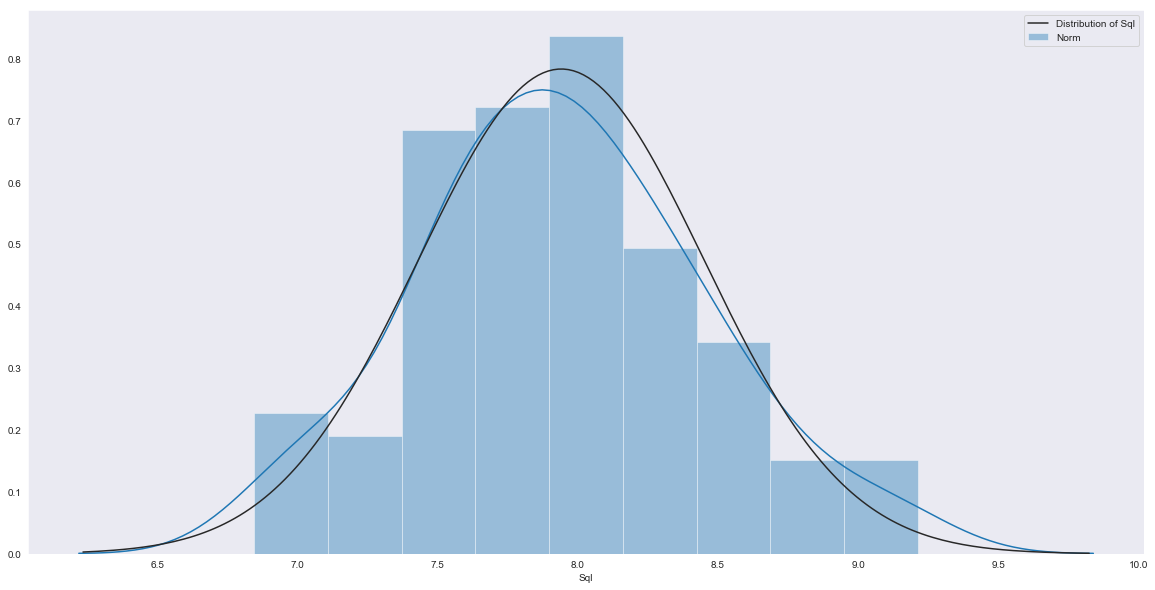

In [207]:
#Ex5
df = pd.read_csv('./Assignment 8 Data Files/sql_scores.csv', header=None, names=['Sql'])

plt.figure(figsize=(20,10))
sns.distplot(df['Sql'], fit=ss.norm, label='Distribution of Sql')
plt.legend(['Distribution of Sql', 'Norm'], loc='upper right')
plt.show()

#the distribution is seem a normal distribution

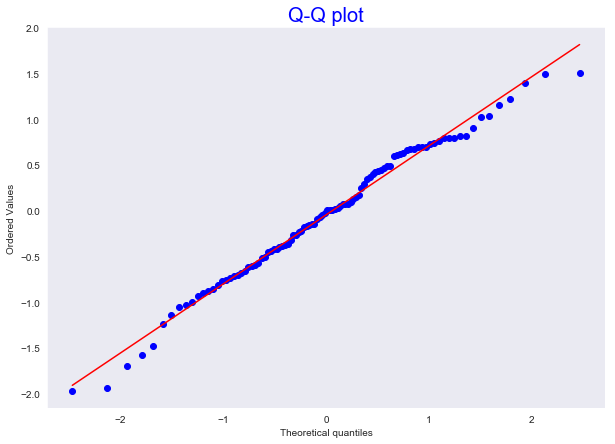

In [208]:
mean = df['Sql'].mean()
std = df['Sql'].std()
norm_dist = norm.rvs(loc=mean, scale=std, size=df['Sql'].shape[0])

diff_ = df['Sql'] - norm_dist

plt.figure(figsize=(10,7))
probplot(diff_, plot=plt)
plt.title('Q-Q plot', fontsize=20, color='b')
plt.show()
#this statistically to see if the data is normally distributed

In [94]:
# H0: sql is normal distribution
# H1: sql isn't normal distribution


sapiro_p = shapiro(df['Sql'])
print('Sapiro test:%.3f' %(sapiro_p[1]))

anderson_test = anderson(df['Sql'], dist='norm')
print('anderson test:%.3f' %(anderson_test[1][2]))

kurtosis_test = mstats.normaltest(df['Sql'])
print('kurtosis test:%.3f' %(kurtosis_test[1]))

# All test have p_value > 0.05 then fail to reject --> normal distribution

Sapiro test:0.717
anderson test:0.759
kurtosis test:0.728


In [210]:
#Ex6
df = pd.read_csv('./Assignment 8 Data Files/iris.csv')

# H0: correlation of each width and length are weekly related
# H1: correlation of each width and length are strongly related

def corr(func):
    for species in np.unique(df['species']):
        data = df[df['species']==species]
        pearsonr_sepal = func(data['sepal_length'], data['sepal_width'])
        pearsonr_petal = func(data['petal_length'], data['petal_width'])
        print('corr of', species, 'for sepal', pearsonr_sepal[0])
        print('corr of', species, 'for petal', pearsonr_petal[0])

print('pearsonr:')        
corr(mstats.pearsonr)
print('-'*20)
print('spearmanr:')
corr(mstats.spearmanr)
print('-'*20)
print('kendalltau:')
corr(mstats.kendalltau)


pearsonr:
corr of setosa for sepal 0.7467803732639268
corr of setosa for petal 0.30630821115803564
corr of versicolor for sepal 0.5259107172828247
corr of versicolor for petal 0.7866680885228168
corr of virginica for sepal 0.4572278163941129
corr of virginica for petal 0.32210821590031835
--------------------
spearmanr:
corr of setosa for sepal 0.768608507372937
corr of setosa for petal 0.22727471454826642
corr of versicolor for sepal 0.5176060253966388
corr of versicolor for petal 0.787009590533796
corr of virginica for sepal 0.426516535285076
corr of virginica for petal 0.3629133150909172
--------------------
kendalltau:
corr of setosa for sepal 0.6101996165406902
corr of setosa for petal 0.1828758734460545
corr of versicolor for sepal 0.3977974304771203
corr of versicolor for petal 0.6457342463161735
corr of virginica for sepal 0.30708686092415427
corr of virginica for petal 0.271414857177997


    student  pre  post
0         1   18    22
1         2   21    25
2         3   16    17
3         4   22    24
4         5   19    16
5         6   24    29
6         7   17    20
7         8   21    23
8         9   23    19
9        10   18    20
10       11   14    15
11       12   16    15
12       13   16    18
13       14   19    26
14       15   18    18
15       16   20    24
16       17   12    18
17       18   22    25
18       19   15    19
19       20   17    16


Text(0.5,1,'Distribution of pre and post')

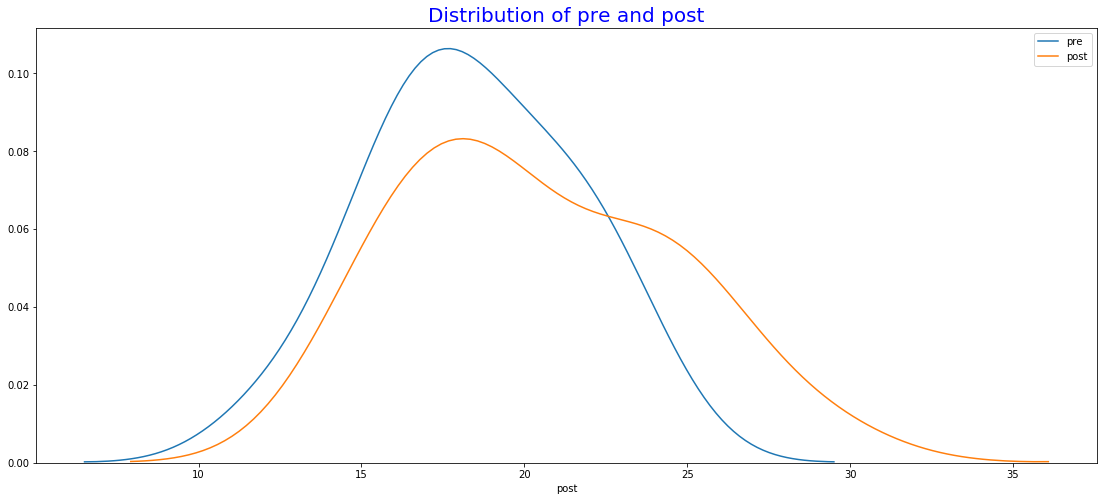

In [2]:
#Ex7
df = pd.read_csv('./Assignment 8 Data Files/scores.csv')
print(df)

plt.figure(figsize=(19,8))
sns.distplot(df['pre'], hist=False, label='pre')
sns.distplot(df['post'], hist=False, label='post')
plt.title('Distribution of pre and post', fontsize=20, color='b')

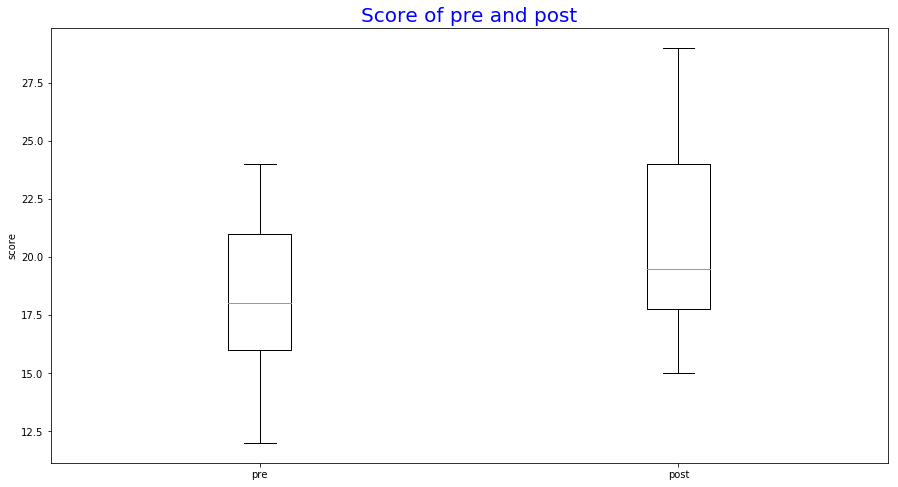

In [3]:
compile_ = [df['pre'].tolist(), df['post'].tolist()]
label = ['pre', 'post']

plt.figure(figsize=(15,8))
plt.boxplot(compile_, labels=label)
plt.ylabel('score')
plt.title('Score of pre and post', fontsize=20, color='b')
plt.show()

#barplot haven't significant outliers

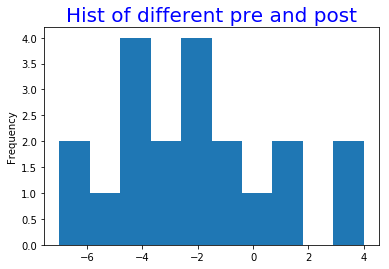

In [4]:
df['different'] = df['pre'] - df['post']
df['different'].plot(kind='hist')
plt.title('Hist of different pre and post', fontsize=20, color='b')
plt.show()
#Hist seem to be a normal distribution

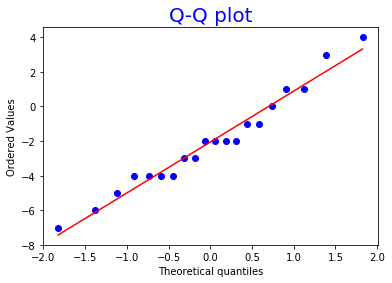

In [5]:
probplot(df['different'], plot=plt)
plt.title('Q-Q plot', fontsize=20, color='b')
plt.show()
#this statistically to see if the data is normally distributed

In [6]:
# H0: normal distribution
# H1: not normal distribution
shapiro(df['different'])
#p=0.725 greater than 0.05 then fail to reject H0 --> normal distribution

(0.968596339225769, 0.7249979376792908)

In [7]:
paired_test = ttest_rel(df['pre'], df['post'])
print(paired_test)
#p = 0.0044/2<0.05 then H0 is rejected

Ttest_relResult(statistic=-3.231252665580312, pvalue=0.004394965993185664)


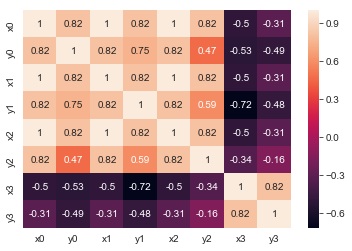

      x0     y0    y1     y2    x3     y3
0    4.0   4.26  3.10   5.39  19.0  12.50
1    5.0   5.68  4.74   5.73   8.0   6.89
2    6.0   7.24  6.13   6.08   8.0   5.25
3    7.0   4.82  7.26   6.42   8.0   7.91
4    8.0   6.95  8.14   6.77   8.0   5.76
5    9.0   8.81  8.77   7.11   8.0   8.84
6   10.0   8.04  9.14   7.46   8.0   6.58
7   11.0   8.33  9.26   7.81   8.0   8.47
8   12.0  10.84  9.13   8.15   8.0   5.56
9   13.0   7.58  8.74  12.74   8.0   7.71
10  14.0   9.96  8.10   8.84   8.0   7.04


In [100]:
#Ex8
df = pd.read_csv('./Assignment 8 Data Files/anscombe.csv')

sns.heatmap(df.corr(), annot=True)
plt.show()

df = df.drop(['x1', 'x2'], axis=1)
df = df.sort_values('x0').reset_index().drop(['index'], axis=1)
print(df)


In [101]:
def corrfunc(x, y, **kws):
    (r, p) = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.3f}".format(r),
                xy=(.4, .9), xycoords=ax.transAxes)

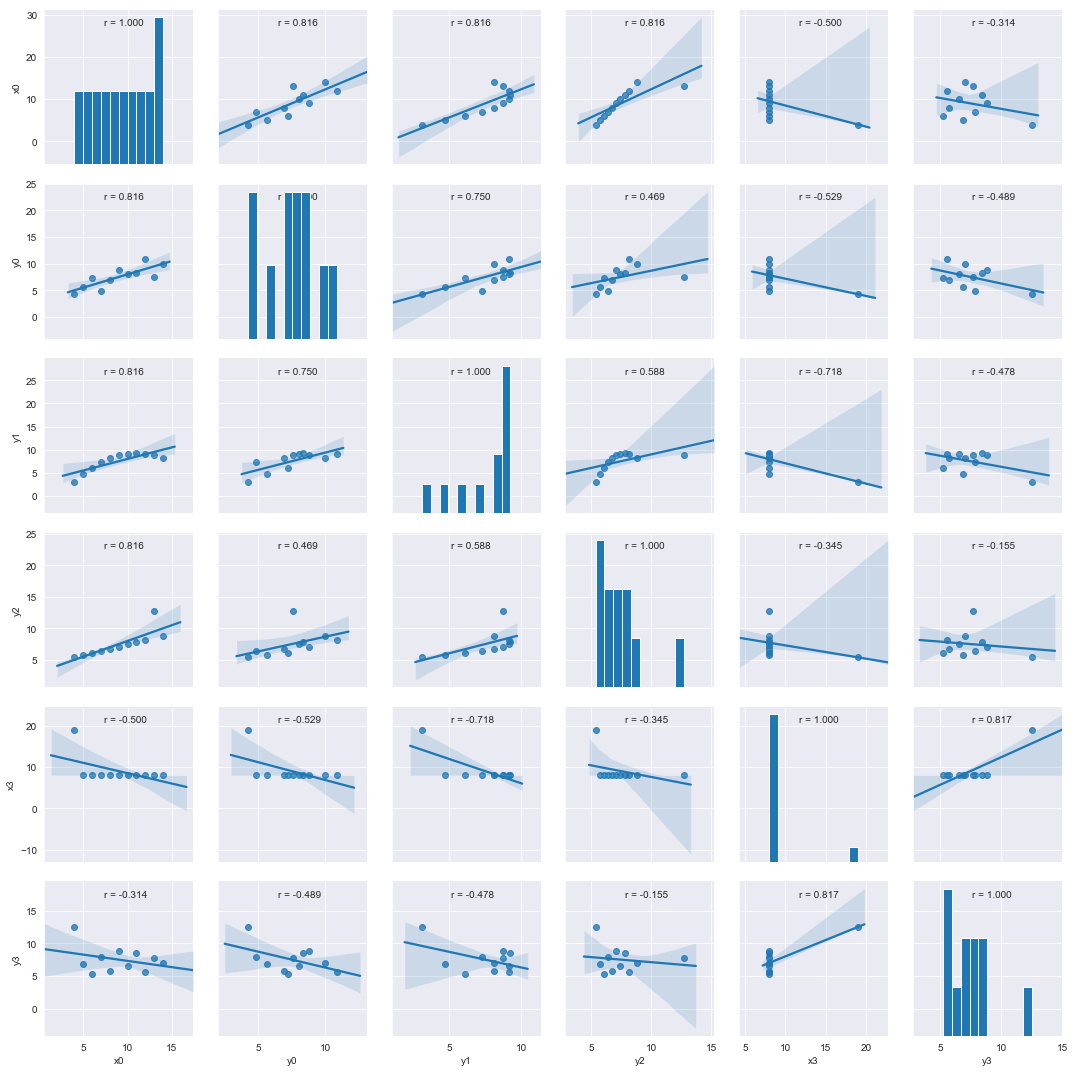

In [104]:
sns.set_style('darkgrid')
g = sns.pairplot(df, kind='reg')
g.map(corrfunc)
plt.show()

In [105]:
up = np.percentile(df['y3'], 99.5)

print(up)

df1 = df.drop(7)
df1 = df1.reset_index().drop(['index', 'x3'], axis=1)
print(df1)

12.316999999999997
     x0     y0    y1     y2     y3
0   4.0   4.26  3.10   5.39  12.50
1   5.0   5.68  4.74   5.73   6.89
2   6.0   7.24  6.13   6.08   5.25
3   7.0   4.82  7.26   6.42   7.91
4   8.0   6.95  8.14   6.77   5.76
5   9.0   8.81  8.77   7.11   8.84
6  10.0   8.04  9.14   7.46   6.58
7  12.0  10.84  9.13   8.15   5.56
8  13.0   7.58  8.74  12.74   7.71
9  14.0   9.96  8.10   8.84   7.04


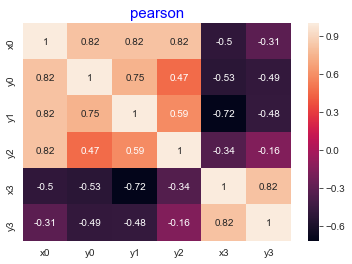

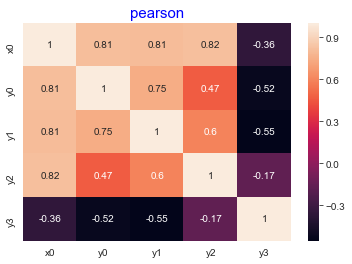

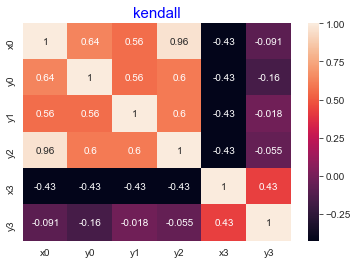

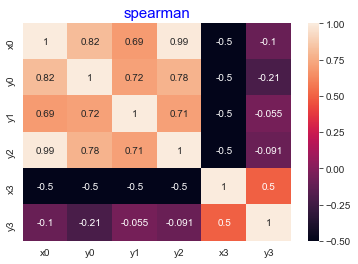

In [106]:
sns.heatmap(df.corr(method='pearson'), annot=True)
plt.title('pearson', fontsize=15, color='b')
plt.show()

sns.heatmap(df1.corr(method='pearson'), annot=True)
plt.title('pearson', fontsize=15, color='b')
plt.show()

sns.heatmap(df.corr(method='kendall'), annot=True)
plt.title('kendall', fontsize=15, color='b')
plt.show()

sns.heatmap(df.corr(method='spearman'), annot=True)
plt.title('spearman', fontsize=15, color='b')
plt.show()


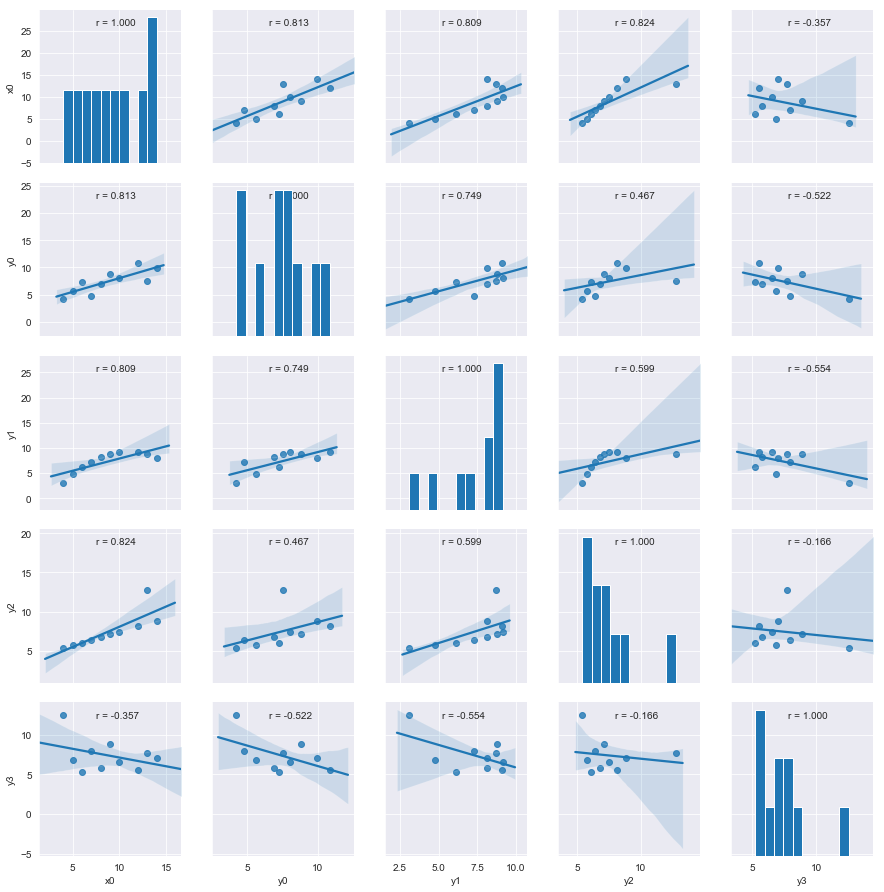

In [107]:
sns.set_style('darkgrid')
g = sns.pairplot(df1, kind='reg')
g.map(corrfunc)
plt.show()

reject H0


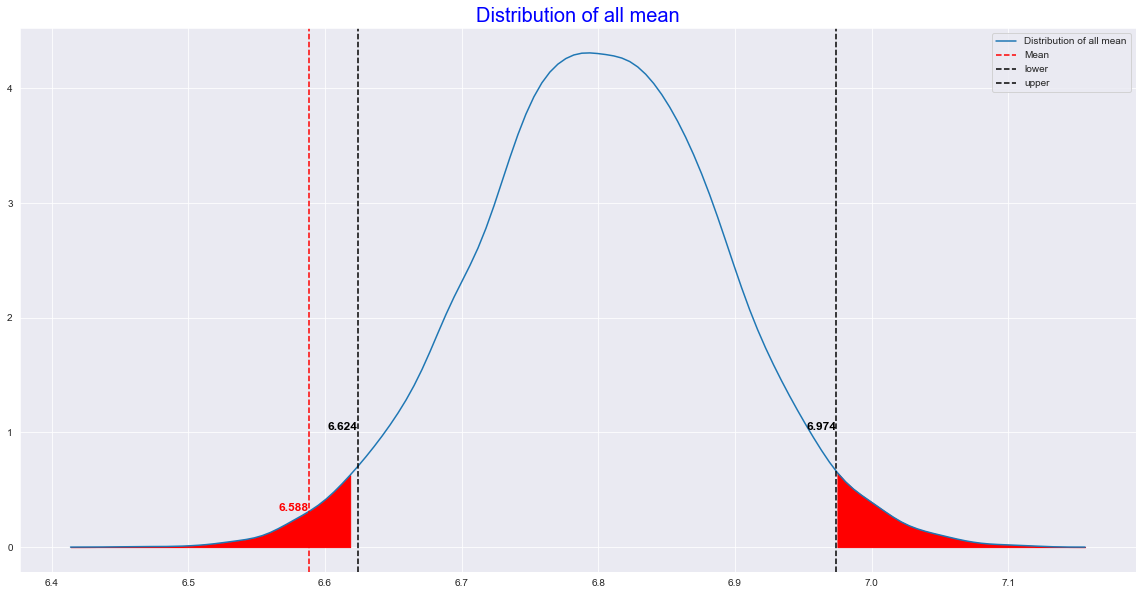

0.009

In [223]:
#Ex9
df = pd.read_csv('./Assignment 8 Data Files/iris.csv')

data = df[df['species']=='virginica']['sepal_length']

number_in_choice = data.shape[0]
anpha = 0.05
value = 6.8
size = 10000

bootstrap(data, number_in_choice, anpha, value, size, 0)
#Virginica sepal lengths is less than 6.8 with 95% CI

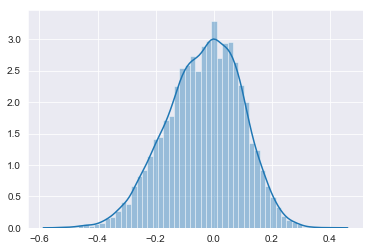

reject H0


0.0257

In [224]:
#Ex10
df = pd.read_csv('./Assignment 8 Data Files/iris.csv')

data = df[df['species']=='virginica']

#H0: sepal lengths and sepal widths related weekly(greater than 0.3)
#H1: sepal lengths and sepal widths related weekly(less than 0.3)

def permutation_corr(sample1, sample0, size, anpha0, anpha):
    
    compiled = np.concatenate((sample1, sample0), axis=0)
    matrix_test = np.zeros((size, 3))
    
    for i in range(size):
        
        np.random.seed(i)
        suffle = np.random.permutation(compiled)
        sample_permutation1 = suffle[:len(sample1)]
        sample_permutation0 = suffle[len(sample1):]
        
        
        matrix_test[i, 0] = mstats.pearsonr(sample_permutation1, sample_permutation0)[0]
        matrix_test[i, 1] = mstats.spearmanr(sample_permutation1, sample_permutation0)[0]
        matrix_test[i, 2] = mstats.kendalltau(sample_permutation1, sample_permutation0)[0]
    
    result_test = np.min(matrix_test, axis=1)
    
    sns.distplot(result_test.ravel())
    plt.show()
    
    p = (result_test[np.abs(result_test)>anpha0].shape[0]/size)
    
    if p > anpha:
        print("Can't reject H0")
    else:
        print('reject H0')
        
    return p

sample1 = data['sepal_length']
sample0 = data['sepal_width']
size = 10000
anpha0 = 0.3
anpha = 0.05

permutation_corr(sample1, sample0, size, anpha0, anpha)
# sepal lengths and sepal widths related weakly with p_value = 0.0257 in correlation less than 0.3 with CI=95%

In [2]:
#Ex12
df = pd.read_csv('./Assignment 8 Data Files/stcp-Rdataset-Diet.csv')
df = df.sort_values('Person')

df['lost'] = df['pre.weight'] - df['weight6weeks']
print(df.head())

   Person gender  Age  Height  pre.weight  Diet  weight6weeks  lost
2       1      0   22     159          58     1          54.2   3.8
3       2      0   46     192          60     1          54.0   6.0
4       3      0   55     170          64     1          63.3   0.7
5       4      0   33     171          64     1          61.1   2.9
6       5      0   50     170          65     1          62.2   2.8


No handles with labels found to put in legend.


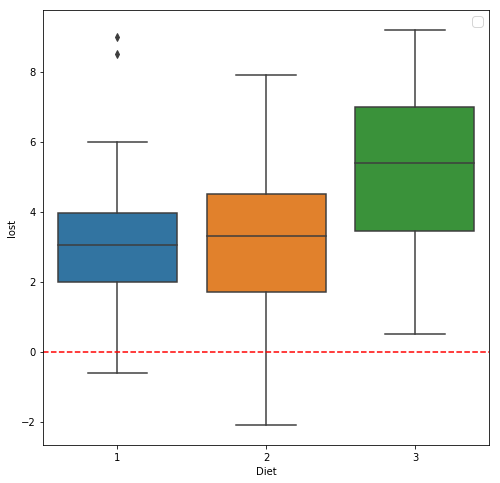

In [4]:
plt.figure(figsize=(8,8))
sns.boxplot(x = 'Diet', y = 'lost', data=df)
plt.axhline(0, ls='--', color='r')
plt.legend(loc='best', fontsize=13)
plt.show()

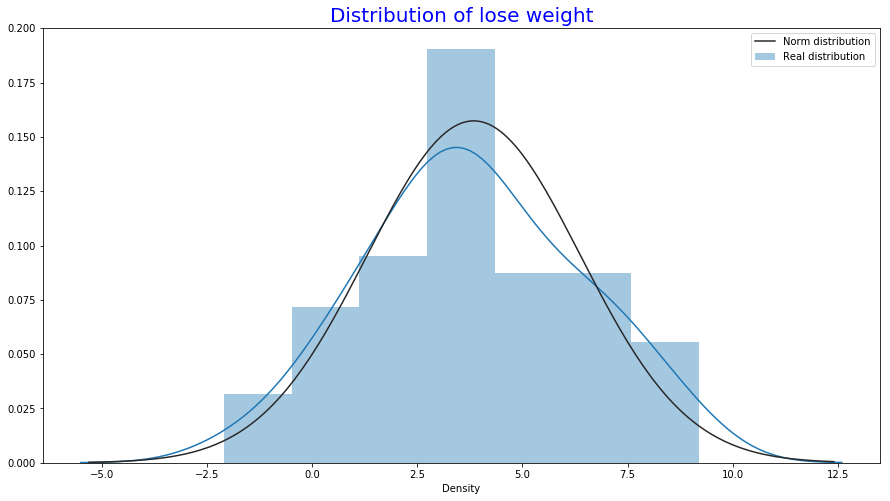

In [5]:
plt.figure(figsize=(15,8))
sns.distplot(df['lost'], fit=ss.norm)
plt.xlabel('Density')
plt.title('Distribution of lose weight', fontsize=20, color='b')
plt.legend(['Norm distribution', 'Real distribution'])
plt.show()
#The grapth seem same normal distribution

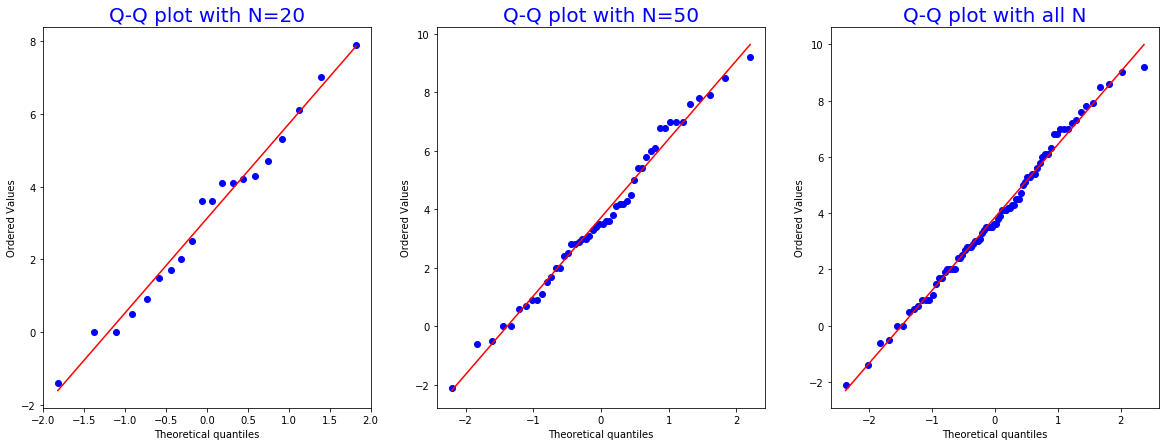

In [6]:
range_list = range(0, df.shape[0])
np.random.seed(5)

range20 = np.random.choice(range_list, 20, replace=False)
df20 = df.iloc[range20,:]

range50 = np.random.choice(range_list, 50, replace=False)
df50 = df.iloc[range50,:]

fig, ax = plt.subplots(1, 3, figsize=(20,7))

probplot(df20['lost'], plot=ax[0])
ax[0].set_title('Q-Q plot with N=20', fontsize=20, color='b')

probplot(df50['lost'], plot=ax[1])
ax[1].set_title('Q-Q plot with N=50', fontsize=20, color='b')

probplot(df['lost'], plot=ax[2])
ax[2].set_title('Q-Q plot with all N', fontsize=20, color='b')

plt.show()
#The grapth seem same normal distribution with all data

In [7]:
# H0: the grapth loss is normal distribution
# H1: the grapth loss isn't normal distribution

shapiro20 = shapiro(df20['lost'])
print('Shapiro test with 20 point: t={}, p_value={}'.format(shapiro20[0], shapiro20[1]))

shapiro50 = shapiro(df50['lost'])
print('Shapiro test with 50 point: t={}, p_value={}'.format(shapiro50[0], shapiro50[1]))

shapiro_test = shapiro(df['lost'])
print('Shapiro test with all point: t={}, p_value={}'.format(shapiro_test[0], shapiro_test[1]))

# p_value greater than 0.05 then fail to reject H0 then normal distribution

Shapiro test with 20 point: t=0.979011058807373, p_value=0.9206990003585815
Shapiro test with 50 point: t=0.9840638637542725, p_value=0.7307355403900146
Shapiro test with all point: t=0.9899073839187622, p_value=0.8019384145736694


In [8]:
df = df.rename(columns={'pre.weight':'pre'})
result = ols('lost ~ pre', data=df).fit()
print(result.predict())

result.summary()
# linear line predict: loss = -0.0262*Height + 8.3192

[3.562363   3.60126095 3.67905684 3.67905684 3.69850581 3.71795478
 3.73740376 3.7763017  3.79575067 3.79575067 3.83464862 3.83464862
 3.83464862 4.02913834 3.81519964 3.83464862 3.87354656 3.95134245
 3.9902404  3.9902404  4.04858731 4.08748526 4.1263832  4.14583218
 3.60126095 4.43756676 3.562363   3.562363   3.58181198 3.62070992
 3.64015889 3.65960787 3.65960787 3.65960787 3.69850581 3.71795478
 3.75685273 3.75685273 3.91244451 3.93189348 3.81519964 3.89299553
 3.89299553 3.91244451 3.95134245 3.95134245 3.97079142 3.97079142
 3.97079142 3.9902404  3.9902404  3.60126095 3.64015889 3.67905684
 3.69850581 3.71795478 3.73740376 3.73740376 3.7763017  3.79575067
 3.79575067 3.83464862 3.83464862 3.85409759 3.89299553 3.91244451
 3.81519964 3.85409759 3.91244451 3.95134245 3.95134245 3.95134245
 3.97079142 4.04858731 4.06803629 4.08748526 4.1263832  4.14583218]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   lost   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.3375
Date:                Wed, 20 Feb 2019   Prob (F-statistic):              0.563
Time:                        08:49:53   Log-Likelihood:                -183.06
No. Observations:                  78   AIC:                             370.1
Df Residuals:                      76   BIC:                             374.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4343      2.445      0.996      0.323      -2.436       7.304
pre            0.0194      0.033      0.581      0.563      -0.047       0.086
==============================================================================
Omnibus:                        0.981   Durbin-Watson:                   1.585
Prob(Omnibus):                  0.612   Jarque-Bera (JB):                0.922
Skew:                           0.042   Prob(JB):                        0.631
Kurtosis:                       2.474   Cond. No.                         616.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

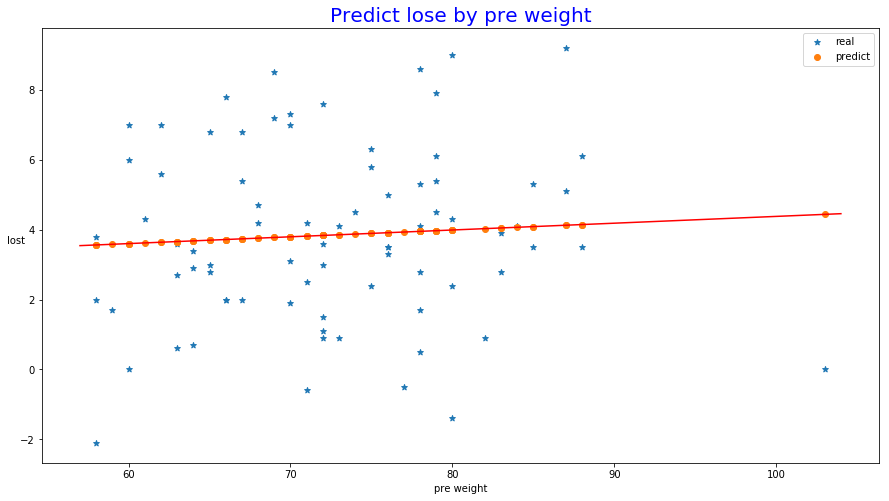

Rsquared: 0.004421562918152877


In [9]:
def predict_linear(x):
    return ((result.params[1])*x + result.params[0])

x_min, x_max = df['pre'].min()-1, df['pre'].max()+1

plt.figure(figsize=(15,8))
plt.scatter(df['pre'], df['lost'], marker='*', label='real')
plt.scatter(df['pre'], result.predict(), label='predict')
plt.plot([x_min, x_max],[predict_linear(x_min), predict_linear(x_max)], color='r')
plt.ylabel('lost', rotation=0)
plt.xlabel('pre weight')
plt.title('Predict lose by pre weight', fontsize=20, color='b')
plt.legend(loc='best')
plt.show()

print('Rsquared:', result.rsquared)

In [10]:
#H0: Diet not related for loss weight
#H1: Diet related for loss weight

result_diet = ols('lost ~ Diet', data=df).fit()

anova_table = sm.stats.anova_lm(result_diet, typ=2)
print(anova_table)

critical_value = ss.f.ppf(q=0.95, dfn=1, dfd=76)
print('critical value:', critical_value)


#  reject H0 because F>critical value then Diet related for loss weight

              sum_sq    df         F    PR(>F)
Diet       45.780976   1.0  7.638673  0.007164
Residual  455.491973  76.0       NaN       NaN
critical value: 3.966759784008781


In [11]:
#H0: lost weight mean in each diet are the same
#H1: lost weight mean in each diet are different

anova_test = f_oneway(df[df['Diet']==1]['lost'], df[df['Diet']==2]['lost'], df[df['Diet']==3]['lost'])
print(anova_test)

# p_value < 0.05 then reject H0 then 3 diet are different

F_onewayResult(statistic=6.197447453165349, pvalue=0.0032290142385893524)


In [12]:
#H0: lost weight median in each diet are the same
#H1: lost weight median in each diet are different
kruskal_test = kruskal(df[df['Diet']==1]['lost'], df[df['Diet']==2]['lost'], df[df['Diet']==3]['lost'])
print(kruskal_test)

# p_value < 0.05 then reject H0 then lost weight median in each diet are different

KruskalResult(statistic=10.436705442077404, pvalue=0.005416243846447252)


In [13]:
df['resid_mean'] = df.groupby('Diet')['lost'].transform(lambda x:(x-x.mean()).round(1))
df['resid_median'] = df.groupby('Diet')['lost'].transform(lambda x:(x-x.median()).round(2))
print(df.head())

   Person gender  Age  Height  pre  Diet  weight6weeks  lost  resid_mean  \
2       1      0   22     159   58     1          54.2   3.8         0.5   
3       2      0   46     192   60     1          54.0   6.0         2.7   
4       3      0   55     170   64     1          63.3   0.7        -2.6   
5       4      0   33     171   64     1          61.1   2.9        -0.4   
6       5      0   50     170   65     1          62.2   2.8        -0.5   

   resid_median  
2          0.75  
3          2.95  
4         -2.35  
5         -0.15  
6         -0.25  


No handles with labels found to put in legend.


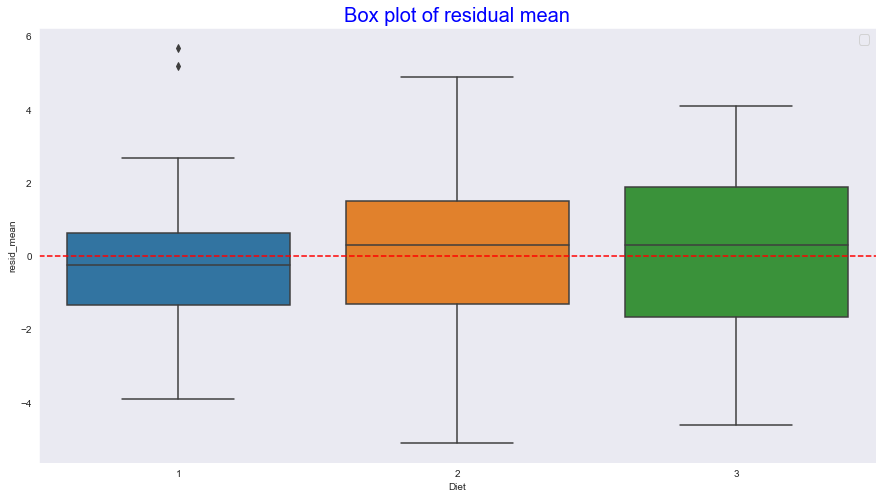

In [14]:
plt.figure(figsize=(15,8))
sns.set_style('dark')
sns.boxplot(x = 'Diet', y = 'resid_mean', data=df)
plt.axhline(0, ls='--', color='r')
plt.title('Box plot of residual mean', fontsize=20, color='b')
plt.legend(loc='best', fontsize=13)
plt.show()

# Diet 1 have mean resid less than 0 otherwise diet2 and diet3 greater than 0

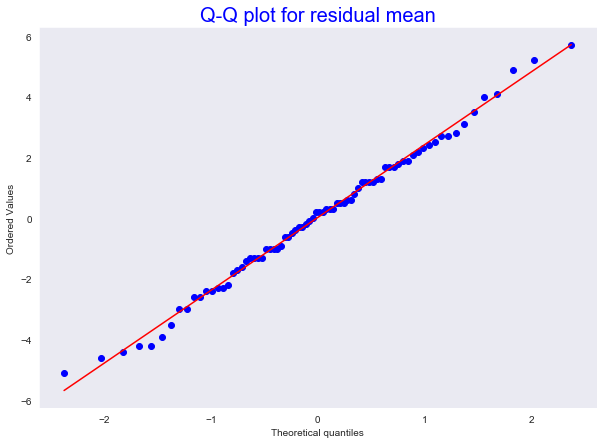

In [15]:
plt.figure(figsize=(10,7))
probplot(df['resid_mean'], plot=plt)
plt.title('Q-Q plot for residual mean', fontsize=20, color='b')
plt.show()
#The grapth seem same normal distribution

In [16]:
shapiro_resid = shapiro(df['resid_mean'])
print(shapiro_resid)
# p<0.05 then residual are normally distributed

(0.99195396900177, 0.9105953574180603)


In [17]:
result_gender = ols('resid_mean ~ Diet + gender', data=df).fit()

result_gender.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             resid_mean   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.139
Date:                Wed, 20 Feb 2019   Prob (F-statistic):              0.339
Time:                        08:49:54   Log-Likelihood:                -175.51
No. Observations:                  78   AIC:                             359.0
Df Residuals:                      74   BIC:                             368.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -3.0360      1.793     -1.693      0.095      -6.609       0.537
gender[T.0]     3.0624      1.705      1.796      0.077      -0.335       6.460
gender[T.1]     3.1595      1.717      1.840      0.070      -0.261       6.580
Diet            0.0180      0.331      0.054      0.957      -0.641       0.677
==============================================================================
Omnibus:                        0.033   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.983   Jarque-Bera (JB):                0.034
Skew:                          -0.021   Prob(JB):                        0.983
Kurtosis:                       2.907   Cond. No.                         27.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
#H0: Gender not related for loss weight
#H1: Gender related for loss weight

anova_gender = sm.stats.anova_lm(result_gender, typ=2)
print(anova_gender)

p_gender_upper = ss.f.ppf(q=0.95, dfn=2, dfd=76)
p_gender_lower = ss.f.ppf(q=0.05, dfn=2, dfd=76)
print(p_gender_upper)
print(p_gender_lower)

p_diet = ss.f.ppf(q=0.95, dfn=1, dfd=76)
print(p_diet)
# upper > F_Gender > lower and p_gender > 0.05 then fail to reject H0 then gender is not related loss weight

              sum_sq    df         F    PR(>F)
gender     18.956565   2.0  1.705628  0.188722
Diet        0.016499   1.0  0.002969  0.956693
Residual  411.222754  74.0       NaN       NaN
3.116981837383118
0.05132792841708845
3.966759784008781
